# This project implemented by Elham Mahdipour
## I am a Ph.D. Graduate  of computer engineering at Yazd University, Yazd, Iran.
## I am a Faculty Member of Computer Engineering Department at Khavaran Institute of Higher Education, Mashhad, Iran.
### Please feel free and contact to me: elham.mahdipour@gmail.com/ e.mahdipour@profs.khi.ac.ir

# Please run all cells for train the LSTM-NA model. This program train LSTM-NA tune model for EC-SC species.

# Phase 1 
## Create Dataset and Preprocessing

In [1]:
import networkx as nx
G1=nx.read_weighted_edgelist('large dataset\sc-sc.evals')
G1

In [2]:
G2=nx.read_weighted_edgelist('large dataset\ec-ec.evals')
G2

In [3]:
### Check and Swap if G1 > G2 ###
if len(G1)>len(G2):
    temp=G1
    G1=G2
    G2=temp
print(len(G1))
print(len(G2))

4265
6613


In [4]:
G_target_na=nx.read_weighted_edgelist('large dataset\ec-sc.evals')
G_target_na  

In [5]:
ed1=G1.edges()
ed2=G2.edges()

nd1=G1.nodes()
nd2=G2.nodes()

el1=list(ed1)
el2=list(ed2)

nd1=list(nd1)
nd2=list(nd2)

degG1 = [val for (node, val) in G1.degree()]
degG2 = [val for (node, val) in G2.degree()]

# Feature Extraction

# compute score for create similarity matrix

In [6]:
def deg_Diff(G1,G2):
    Degree_Difference=np.zeros((len(G1),len(G2)))
    for i in range(len(G1)):
        for j in range(len(G2)):
            Degree_Difference[i][j]=abs(degG1[i]-degG2[j])/max(degG1[i],degG2[j])
    return Degree_Difference

In [7]:
def score_pageRank(X):
    a=nx.pagerank(X)
    return a

In [8]:
def coefficient_pagerank(x,y):  #x is G1, y is G2
   # print(len(x))
    p1=score_pageRank(x)
    b=p1.values()
    pr1=list(b)
    p2=score_pageRank(y)
    c=p2.values()
    pr2=list(c)
    pr=np.zeros((len(x),len(y)))
    for i in range(len(x)):
        for j in range(len(y)):
            #print(pr1[i],pr2[j])
            pr[i][j]=abs(pr1[i]-pr2[j])/max(pr1[i],pr2[j])   #minimum pr is maximum similarity of topology 
    return pr

In [9]:
def coefficient_edges(index_node, G, GraphNumber):
    if GraphNumber==1:
        sum_edge=0        
        for i in G.neighbors(nd1[index_node]):                       
            sum_edge=sum_edge+degG1[nd1.index(i)]
        #print(sum_edge)
        temp=(degG1[index_node]-1) if degG1[index_node]> 1 else 1        
        coeff_node=(2*sum_edge)/(degG1[index_node]*temp)
    else:
        sum_edge=0        
        for i in G.neighbors(nd2[index_node]):                       
            sum_edge=sum_edge+degG2[nd2.index(i)]
        #print(sum_edge)
        temp=(degG2[index_node]-1) if degG2[index_node]> 1 else 1        
        coeff_node=(2*sum_edge)/(degG2[index_node]*temp)
    return coeff_node

In [10]:
def compute_Ea(G1,G2):
    Ea_G1=np.zeros(len(G1))
    Ea_G2=np.zeros(len(G2))
    for i in range(len(G1)):
        Ea_G1[i]=coefficient_edges(i, G1, 1)
    for j in range(len(G2)):
        Ea_G2[j]=coefficient_edges(j,G2,2)
    ea=[Ea_G1, Ea_G2]
    return(ea)

In [11]:
# compute relative clustering coefficient difference between node a (in G1) and node b (in G2)
def CD(G1, G2):
    cd=np.zeros((len(G1),len(G2)))
    EA=compute_Ea(G1,G2)
    #print(EA[0])      #Ea for G1
    #print("===================")
    #print(EA[1])      #Ea for G2
    for i in range(len(G1)):
        for j in range(len(G2)):
            cd[i,j]=abs(EA[0][i]-EA[1][j])/max(EA[0][i],EA[1][j])
    return cd

In [12]:
def sequence_score(x,y):
    seq=np.zeros((len(x),len(y)))
    for i in range(len(x)):
        for j in range(len(y)):
            q1=G_target_na.get_edge_data(str(nd1[i]),str(nd2[j]))
            if q1==None:
                c=0
            else:
                c=list(q1.values())
                c=c[0]
            seq[i][j]=c    
            
    return seq

In [13]:
def compute_score(G1,G2):
    coeff_pr=coefficient_pagerank(G1,G2)
    dd=deg_Diff(G1,G2)
    cd=CD(G1,G2)
    seq_sc=sequence_score(G1,G2)
    
    alpha=0.1
    betta=0.2
    gamma=0.2
    zetta=1-alpha-betta-gamma
    s=alpha*(1-coeff_pr)+betta*(1-dd)+gamma*(1-cd)+zetta*seq_sc
    return s,coeff_pr, dd, cd

In [14]:
import numpy as np
m, coeff_pr, dd, cd=compute_score(G1,G2)
sim=m

# Phase 2: Dataset Generation

# create data for deep learning

# change problem to classification 
## [node of G1, node of G2, Coefficient page rank, clustering coefficient difference,  similarity score, alignment=yes(0)/TN or no(1)/TP]

In [15]:
import numpy as np
int_nd1=np.zeros(len(nd1))
int_nd2=np.zeros(len(nd2))

species=['ec','sc','ce','dm','mm','hs']
ch1=0  #please set index for first species of species list, for example index of ec is 0
ch2=1  #please set index for second species of species list, for example index of sc is 1
# If don't set index with considering species may be given an error
for i in range(len(nd1)):
    if (species[ch1] in nd1[i] or species[ch2] in nd1[i]):
        s=nd1[i][2:]
        x=int(s)
        int_nd1[i]=x    
for i in range(len(nd2)):
    if (species[ch1] in nd2[i] or species[ch2] in nd2[i]):
        s=nd2[i][2:]
        x=int(s)
        int_nd2[i]=x    

In [16]:
# en_mat is encoding matrix
en_mat=[]

for i in range(len(nd1)):
    for j in range(len(nd2)):
        if G_target_na.has_edge(nd1[i],nd2[j]):
            align_class='Yes'
        else:
            align_class='No'
        
        sample=[int_nd1[i],int_nd2[j], coeff_pr[i][j], dd[i][j],cd[i][j],sim[i][j],align_class] 
        en_mat.append(sample)
print(len(en_mat))

28204445


In [17]:
yc=[]
noc=[]
for i in range(len(en_mat)):
    if en_mat[i][6]=='Yes':
        yc.append(en_mat[i])
    else:
        noc.append(en_mat[i])
print(len(yc), len(noc))

4561 28199884


In [18]:
from random import shuffle
noc.sort(key = lambda i: i[6])
data=yc+noc[0:len(yc)] 
shuffle(data)
X=[]
y=[]
for i in range(len(data)):
    X.append(data[i][0:6])
    y.append(data[i][6])

len(X),len(y)

(9122, 9122)

In [36]:
data=yc+noc 
len(data)
X=[]
y=[]
for i in range(len(data)):
    X.append(data[i][0:6])
    y.append(data[i][6])

len(X),len(y)

(28204445, 28204445)

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [20]:
print(len(X_train), len(y_train), len(X_test), len(y_test))

8209 8209 913 913


In [20]:
x_tr,y_tr,x_te,y_te=X_train, y_train,X_test,y_test

# test model for real data

In [20]:
# Label encode Class (Species)
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_Y = encoder.transform(y_train)
# One Hot Encode
y_train = np_utils.to_categorical(encoded_Y)

Using TensorFlow backend.
C:\Users\ASUS\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\ASUS\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\ASUS\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\ASUS\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519

In [22]:
# Label encode Class (Species)
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
encoder = LabelEncoder()
encoder.fit(y_test)
encoded_Y = encoder.transform(y_test)
# One Hot Encode
y_test = np_utils.to_categorical(encoded_Y)

In [23]:
import numpy as np
X_train=np.array(X_train)
y_train=np.array(y_train)
X_test=np.array(X_test)
y_test=np.array(y_test)

In [37]:
# Label encode Class (Species)
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y = encoder.transform(y)
# One Hot Encode
y_test = np_utils.to_categorical(encoded_Y)

In [38]:
import numpy as np
X_test=np.array(X)
y_test=np.array(y_test)

# Phase 3: Architecture of LSTM-NA Network

# Train model with resample

In [28]:
from keras import Sequential
from keras.layers import Dense,LSTM,Embedding
from keras import layers
import keras
callbacks_list = [keras.callbacks.EarlyStopping(monitor='loss',patience=1,),
keras.callbacks.ModelCheckpoint(filepath='my_model.h5',monitor='val_loss',save_best_only=True,)]

model_lstm = Sequential()

model_lstm.add(layers.Embedding(6, 8))
model_lstm.add(layers.LSTM(4))
model_lstm.add(Dense(2, activation='softmax'))
model_lstm.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['acc','mae','mse'])
model_lstm.summary()
history_lstm = model_lstm.fit(X_train, y_train,epochs=1000,validation_split=0.2,callbacks=callbacks_list)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 8)           48        
_________________________________________________________________
lstm_4 (LSTM)                (None, 4)                 208       
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 10        
Total params: 266
Trainable params: 266
Non-trainable params: 0
_________________________________________________________________
Train on 6567 samples, validate on 1642 samples
Epoch 1/1000
6567/6567 [==============================] - 1s 214us/step - loss: 0.6917 - acc: 0.5354 - mae: 0.4992 - mse: 0.2493 - val_loss: 0.6907 - val_acc: 0.4787 - val_mae: 0.4987 - val_mse: 0.2488
Epoch 2/1000
6567/6567 [==============================] - 1s 166us/step - loss: 0.6878 - acc: 0.5050 - mae: 0.4972 - mse: 0.2473 - val_l

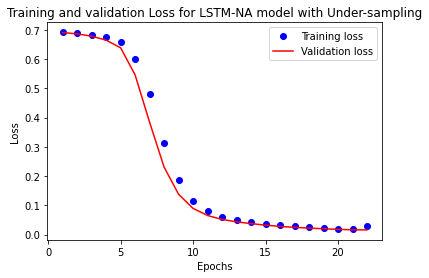

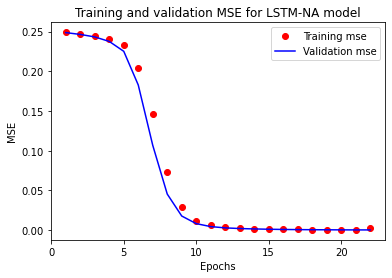

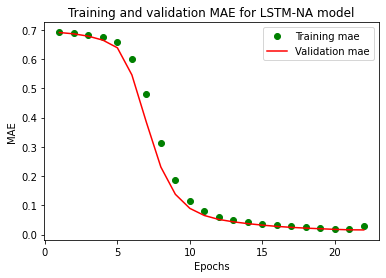

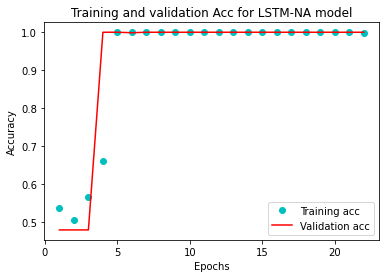

In [29]:
import matplotlib.pyplot as plt
loss = history_lstm.history['loss']
val_loss = history_lstm.history['val_loss']
mse = history_lstm.history['mse']
val_mse = history_lstm.history['val_mse']
mae = history_lstm.history['mae']
val_mae = history_lstm.history['val_mae']
acc = history_lstm.history['acc']
val_acc = history_lstm.history['val_acc']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation Loss for LSTM-NA model with Under-sampling')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, mse, 'ro', label='Training mse')
plt.plot(epochs, val_mse, 'b', label='Validation mse')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Training and validation MSE for LSTM-NA model')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, loss, 'go', label='Training mae')
plt.plot(epochs, val_loss, 'r', label='Validation mae')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('Training and validation MAE for LSTM-NA model')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, acc, 'co', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and validation Acc for LSTM-NA model')
plt.legend()
plt.show()


In [24]:
from keras import Sequential
from keras.layers import Dense,LSTM,Embedding
from keras import layers
import keras
#callbacks_list = [keras.callbacks.EarlyStopping(monitor='acc',patience=1,),
#keras.callbacks.ModelCheckpoint(filepath='my_model.h5',monitor='val_loss',save_best_only=True,)]

model_lstm = Sequential()

model_lstm.add(layers.Embedding(6, 8))
model_lstm.add(layers.LSTM(4))
model_lstm.add(Dense(2, activation='softmax'))
model_lstm.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['acc','mae','mse'])
model_lstm.summary()
history_lstm = model_lstm.fit(X_train, y_train,epochs=1000,validation_split=0.2)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 8)           48        
_________________________________________________________________
lstm_2 (LSTM)                (None, 4)                 208       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 10        
Total params: 266
Trainable params: 266
Non-trainable params: 0
_________________________________________________________________
Train on 6567 samples, validate on 1642 samples
Epoch 1/1000
6567/6567 [==============================] - 1s 216us/step - loss: 0.6901 - acc: 0.5514 - mae: 0.4985 - mse: 0.2485 - val_loss: 0.6865 - val_acc: 1.0000 - val_mae: 0.4966 - val_mse: 0.2467
Epoch 2/1000
6567/6567 [==============================] - 1s 167us/step - loss: 0.6831 - acc: 0.9499 - mae: 0.4949 - mse: 0.2450 - val_l

Epoch 37/1000
6567/6567 [==============================] - 1s 175us/step - loss: 0.0166 - acc: 1.0000 - mae: 0.0164 - mse: 3.2025e-04 - val_loss: 0.0131 - val_acc: 1.0000 - val_mae: 0.0171 - val_mse: 3.4465e-04
Epoch 38/1000
6567/6567 [==============================] - 1s 175us/step - loss: 0.0173 - acc: 1.0000 - mae: 0.0171 - mse: 3.4449e-04 - val_loss: 0.0134 - val_acc: 1.0000 - val_mae: 0.0174 - val_mse: 3.5208e-04
Epoch 39/1000
6567/6567 [==============================] - 1s 170us/step - loss: 0.0179 - acc: 1.0000 - mae: 0.0177 - mse: 3.7429e-04 - val_loss: 0.0139 - val_acc: 1.0000 - val_mae: 0.0181 - val_mse: 3.8050e-04
Epoch 40/1000
6567/6567 [==============================] - 1s 165us/step - loss: 0.0185 - acc: 1.0000 - mae: 0.0183 - mse: 3.9689e-04 - val_loss: 0.0145 - val_acc: 1.0000 - val_mae: 0.0188 - val_mse: 4.1137e-04
Epoch 41/1000
6567/6567 [==============================] - 1s 167us/step - loss: 0.0192 - acc: 1.0000 - mae: 0.0190 - mse: 4.2717e-04 - val_loss: 0.0149 - v

Epoch 77/1000
6567/6567 [==============================] - 1s 168us/step - loss: 0.0267 - acc: 1.0000 - mae: 0.0264 - mse: 8.1083e-04 - val_loss: 0.1635 - val_acc: 1.0000 - val_mae: 0.0260 - val_mse: 7.3126e-04
Epoch 78/1000
6567/6567 [==============================] - 1s 178us/step - loss: 0.0259 - acc: 1.0001 - mae: 0.0255 - mse: 7.0279e-04 - val_loss: 0.1630 - val_acc: 1.0000 - val_mae: 0.0254 - val_mse: 6.9208e-04
Epoch 79/1000
6567/6567 [==============================] - 1s 167us/step - loss: 0.0252 - acc: 1.0000 - mae: 0.0249 - mse: 7.6424e-04 - val_loss: 0.1610 - val_acc: 1.0000 - val_mae: 0.0247 - val_mse: 6.5494e-04
Epoch 80/1000
6567/6567 [==============================] - 1s 182us/step - loss: 0.0245 - acc: 1.0001 - mae: 0.0242 - mse: 6.3122e-04 - val_loss: 0.1603 - val_acc: 1.0000 - val_mae: 0.0240 - val_mse: 6.2086e-04
Epoch 81/1000
6567/6567 [==============================] - 1s 168us/step - loss: 0.0239 - acc: 1.0000 - mae: 0.0236 - mse: 7.1122e-04 - val_loss: 0.1602 - v

Epoch 116/1000
6567/6567 [==============================] - 1s 173us/step - loss: 0.0124 - acc: 1.0000 - mae: 0.0123 - mse: 2.2029e-04 - val_loss: 0.0930 - val_acc: 1.0000 - val_mae: 0.0123 - val_mse: 1.6118e-04
Epoch 117/1000
6567/6567 [==============================] - 1s 187us/step - loss: 0.0122 - acc: 1.0001 - mae: 0.0121 - mse: 2.3258e-04 - val_loss: 0.0935 - val_acc: 1.0000 - val_mae: 0.0121 - val_mse: 1.5772e-04
Epoch 118/1000
6567/6567 [==============================] - 1s 177us/step - loss: 0.0121 - acc: 1.0001 - mae: 0.0120 - mse: 2.0054e-04 - val_loss: 0.0943 - val_acc: 1.0000 - val_mae: 0.0120 - val_mse: 1.5449e-04
Epoch 119/1000
6567/6567 [==============================] - 1s 173us/step - loss: 0.0119 - acc: 1.0000 - mae: 0.0119 - mse: 2.0402e-04 - val_loss: 0.0943 - val_acc: 1.0000 - val_mae: 0.0118 - val_mse: 1.4962e-04
Epoch 120/1000
6567/6567 [==============================] - 1s 173us/step - loss: 0.0117 - acc: 1.0001 - mae: 0.0117 - mse: 2.1235e-04 - val_loss: 0.094

Epoch 155/1000
6567/6567 [==============================] - 1s 178us/step - loss: 0.0084 - acc: 1.0001 - mae: 0.0083 - mse: 1.4449e-04 - val_loss: 0.1052 - val_acc: 1.0000 - val_mae: 0.0084 - val_mse: 7.3853e-05
Epoch 156/1000
6567/6567 [==============================] - 1s 180us/step - loss: 0.0083 - acc: 1.0001 - mae: 0.0083 - mse: 1.4502e-04 - val_loss: 0.1049 - val_acc: 1.0000 - val_mae: 0.0083 - val_mse: 7.2367e-05
Epoch 157/1000
6567/6567 [==============================] - 1s 173us/step - loss: 0.0083 - acc: 1.0001 - mae: 0.0082 - mse: 7.1564e-05 - val_loss: 0.1049 - val_acc: 1.0000 - val_mae: 0.0083 - val_mse: 7.2100e-05
Epoch 158/1000
6567/6567 [==============================] - 1s 176us/step - loss: 0.0082 - acc: 1.0001 - mae: 0.0082 - mse: 1.1340e-04 - val_loss: 0.1046 - val_acc: 1.0000 - val_mae: 0.0082 - val_mse: 7.0536e-05
Epoch 159/1000
6567/6567 [==============================] - 1s 173us/step - loss: 0.0082 - acc: 1.0001 - mae: 0.0081 - mse: 1.3774e-04 - val_loss: 0.105

Epoch 194/1000
6567/6567 [==============================] - 1s 195us/step - loss: 0.0072 - acc: 1.0001 - mae: 0.0073 - mse: 1.3672e-04 - val_loss: 0.1203 - val_acc: 1.0000 - val_mae: 0.0072 - val_mse: 5.3337e-05
Epoch 195/1000
6567/6567 [==============================] - 1s 192us/step - loss: 0.0072 - acc: 1.0001 - mae: 0.0072 - mse: 5.2830e-05 - val_loss: 0.1198 - val_acc: 1.0000 - val_mae: 0.0072 - val_mse: 5.2934e-05
Epoch 196/1000
6567/6567 [==============================] - 1s 191us/step - loss: 0.0072 - acc: 1.0001 - mae: 0.0072 - mse: 8.7815e-05 - val_loss: 0.1204 - val_acc: 1.0000 - val_mae: 0.0072 - val_mse: 5.2766e-05
Epoch 197/1000
6567/6567 [==============================] - 1s 189us/step - loss: 0.0072 - acc: 0.9999 - mae: 0.0071 - mse: 1.3590e-04 - val_loss: 0.1199 - val_acc: 1.0000 - val_mae: 0.0071 - val_mse: 5.1948e-05
Epoch 198/1000
6567/6567 [==============================] - 1s 206us/step - loss: 0.0072 - acc: 1.0001 - mae: 0.0071 - mse: 1.1407e-04 - val_loss: 0.121

Epoch 233/1000
6567/6567 [==============================] - 1s 178us/step - loss: 0.0063 - acc: 1.0001 - mae: 0.0063 - mse: 1.3097e-04 - val_loss: 0.1293 - val_acc: 1.0000 - val_mae: 0.0062 - val_mse: 3.9663e-05
Epoch 234/1000
6567/6567 [==============================] - 1s 177us/step - loss: 0.0063 - acc: 1.0001 - mae: 0.0063 - mse: 1.0896e-04 - val_loss: 0.1310 - val_acc: 1.0000 - val_mae: 0.0063 - val_mse: 3.9942e-05
Epoch 235/1000
6567/6567 [==============================] - 1s 179us/step - loss: 0.0062 - acc: 1.0000 - mae: 0.0062 - mse: 9.8163e-05 - val_loss: 0.1309 - val_acc: 1.0000 - val_mae: 0.0062 - val_mse: 3.9224e-05
Epoch 236/1000
6567/6567 [==============================] - 1s 177us/step - loss: 0.0062 - acc: 1.0000 - mae: 0.0062 - mse: 1.4172e-04 - val_loss: 0.1315 - val_acc: 1.0000 - val_mae: 0.0062 - val_mse: 3.9540e-05
Epoch 237/1000
6567/6567 [==============================] - 1s 175us/step - loss: 0.0062 - acc: 1.0001 - mae: 0.0063 - mse: 1.1947e-04 - val_loss: 0.131

Epoch 310/1000
6567/6567 [==============================] - 1s 174us/step - loss: 0.0051 - acc: 1.0000 - mae: 0.0051 - mse: 7.8910e-05 - val_loss: 0.1469 - val_acc: 1.0000 - val_mae: 0.0051 - val_mse: 2.6174e-05
Epoch 311/1000
6567/6567 [==============================] - 1s 172us/step - loss: 0.0051 - acc: 1.0000 - mae: 0.0051 - mse: 9.6952e-05 - val_loss: 0.1493 - val_acc: 1.0000 - val_mae: 0.0051 - val_mse: 2.6688e-05
Epoch 312/1000
6567/6567 [==============================] - 1s 174us/step - loss: 0.0051 - acc: 1.0001 - mae: 0.0051 - mse: 7.4694e-05 - val_loss: 0.1485 - val_acc: 1.0000 - val_mae: 0.0051 - val_mse: 2.6273e-05
Epoch 313/1000
6567/6567 [==============================] - 1s 175us/step - loss: 0.0051 - acc: 1.0001 - mae: 0.0051 - mse: 8.6072e-05 - val_loss: 0.1475 - val_acc: 1.0000 - val_mae: 0.0050 - val_mse: 2.5814e-05
Epoch 314/1000
6567/6567 [==============================] - 1s 172us/step - loss: 0.0051 - acc: 1.0001 - mae: 0.0050 - mse: 8.1340e-05 - val_loss: 0.148

Epoch 349/1000
6567/6567 [==============================] - 1s 196us/step - loss: 0.0048 - acc: 1.0001 - mae: 0.0048 - mse: 9.7086e-05 - val_loss: 0.1591 - val_acc: 1.0000 - val_mae: 0.0048 - val_mse: 2.3646e-05
Epoch 350/1000
6567/6567 [==============================] - 1s 203us/step - loss: 0.0048 - acc: 1.0001 - mae: 0.0048 - mse: 6.7144e-05 - val_loss: 0.1585 - val_acc: 1.0000 - val_mae: 0.0048 - val_mse: 2.3292e-05
Epoch 351/1000
6567/6567 [==============================] - 1s 197us/step - loss: 0.0048 - acc: 1.0001 - mae: 0.0048 - mse: 8.9872e-05 - val_loss: 0.1586 - val_acc: 1.0000 - val_mae: 0.0048 - val_mse: 2.3177e-05
Epoch 352/1000
6567/6567 [==============================] - 1s 184us/step - loss: 0.0048 - acc: 1.0000 - mae: 0.0048 - mse: 7.7184e-05 - val_loss: 0.1609 - val_acc: 1.0000 - val_mae: 0.0049 - val_mse: 2.3779e-05
Epoch 353/1000
6567/6567 [==============================] - 1s 173us/step - loss: 0.0048 - acc: 1.0000 - mae: 0.0048 - mse: 8.1963e-05 - val_loss: 0.160

Epoch 388/1000
6567/6567 [==============================] - 1s 175us/step - loss: 0.0046 - acc: 1.0001 - mae: 0.0047 - mse: 8.2568e-05 - val_loss: 0.1685 - val_acc: 1.0000 - val_mae: 0.0046 - val_mse: 2.1427e-05
Epoch 389/1000
6567/6567 [==============================] - 1s 175us/step - loss: 0.0046 - acc: 1.0001 - mae: 0.0046 - mse: 7.8717e-05 - val_loss: 0.1684 - val_acc: 1.0000 - val_mae: 0.0046 - val_mse: 2.1332e-05
Epoch 390/1000
6567/6567 [==============================] - 1s 174us/step - loss: 0.0046 - acc: 1.0001 - mae: 0.0046 - mse: 7.7009e-05 - val_loss: 0.1696 - val_acc: 1.0000 - val_mae: 0.0046 - val_mse: 2.1444e-05
Epoch 391/1000
6567/6567 [==============================] - 1s 174us/step - loss: 0.0046 - acc: 1.0000 - mae: 0.0046 - mse: 2.1406e-05 - val_loss: 0.1695 - val_acc: 1.0000 - val_mae: 0.0046 - val_mse: 2.1427e-05
Epoch 392/1000
6567/6567 [==============================] - 1s 174us/step - loss: 0.0046 - acc: 1.0001 - mae: 0.0046 - mse: 9.3079e-05 - val_loss: 0.169

Epoch 427/1000
6567/6567 [==============================] - 1s 176us/step - loss: 0.0048 - acc: 1.0001 - mae: 0.0048 - mse: 2.2644e-05 - val_loss: 0.1902 - val_acc: 1.0000 - val_mae: 0.0048 - val_mse: 2.2676e-05
Epoch 428/1000
6567/6567 [==============================] - 1s 177us/step - loss: 0.0048 - acc: 1.0001 - mae: 0.0048 - mse: 1.1309e-04 - val_loss: 0.1906 - val_acc: 1.0000 - val_mae: 0.0048 - val_mse: 2.2614e-05
Epoch 429/1000
6567/6567 [==============================] - 1s 175us/step - loss: 0.0048 - acc: 1.0001 - mae: 0.0048 - mse: 2.2654e-05 - val_loss: 0.1911 - val_acc: 1.0000 - val_mae: 0.0048 - val_mse: 2.2728e-05
Epoch 430/1000
6567/6567 [==============================] - 1s 176us/step - loss: 0.0048 - acc: 1.0001 - mae: 0.0047 - mse: 2.2478e-05 - val_loss: 0.1895 - val_acc: 1.0000 - val_mae: 0.0047 - val_mse: 2.2274e-05
Epoch 431/1000
6567/6567 [==============================] - 1s 174us/step - loss: 0.0048 - acc: 1.0001 - mae: 0.0047 - mse: 2.2517e-05 - val_loss: 0.191

Epoch 466/1000
6567/6567 [==============================] - 1s 176us/step - loss: 0.0047 - acc: 1.0001 - mae: 0.0047 - mse: 6.5395e-05 - val_loss: 0.2030 - val_acc: 1.0000 - val_mae: 0.0047 - val_mse: 2.1912e-05
Epoch 467/1000
6567/6567 [==============================] - 1s 183us/step - loss: 0.0047 - acc: 1.0001 - mae: 0.0047 - mse: 8.3761e-05 - val_loss: 0.2034 - val_acc: 1.0000 - val_mae: 0.0047 - val_mse: 2.1828e-05
Epoch 468/1000
6567/6567 [==============================] - 1s 176us/step - loss: 0.0047 - acc: 1.0001 - mae: 0.0047 - mse: 7.2237e-05 - val_loss: 0.2024 - val_acc: 1.0000 - val_mae: 0.0046 - val_mse: 2.1505e-05
Epoch 469/1000
6567/6567 [==============================] - 1s 175us/step - loss: 0.0047 - acc: 1.0000 - mae: 0.0047 - mse: 2.1683e-05 - val_loss: 0.2052 - val_acc: 1.0000 - val_mae: 0.0047 - val_mse: 2.2087e-05
Epoch 470/1000
6567/6567 [==============================] - 1s 176us/step - loss: 0.0047 - acc: 1.0001 - mae: 0.0047 - mse: 8.5628e-05 - val_loss: 0.206

Epoch 505/1000
6567/6567 [==============================] - 1s 190us/step - loss: 0.0043 - acc: 1.0000 - mae: 0.0043 - mse: 1.8896e-05 - val_loss: 0.2043 - val_acc: 1.0000 - val_mae: 0.0043 - val_mse: 1.8889e-05
Epoch 506/1000
6567/6567 [==============================] - 1s 179us/step - loss: 0.0043 - acc: 1.0001 - mae: 0.0043 - mse: 7.4473e-05 - val_loss: 0.2039 - val_acc: 1.0000 - val_mae: 0.0043 - val_mse: 1.8696e-05
Epoch 507/1000
6567/6567 [==============================] - 1s 174us/step - loss: 0.0043 - acc: 1.0000 - mae: 0.0043 - mse: 7.0605e-05 - val_loss: 0.2029 - val_acc: 1.0000 - val_mae: 0.0043 - val_mse: 1.8474e-05
Epoch 508/1000
6567/6567 [==============================] - 1s 175us/step - loss: 0.0043 - acc: 1.0001 - mae: 0.0043 - mse: 8.6389e-05 - val_loss: 0.2024 - val_acc: 1.0000 - val_mae: 0.0043 - val_mse: 1.8289e-05
Epoch 509/1000
6567/6567 [==============================] - 1s 174us/step - loss: 0.0043 - acc: 1.0001 - mae: 0.0042 - mse: 7.4870e-05 - val_loss: 0.201

Epoch 544/1000
6567/6567 [==============================] - 1s 173us/step - loss: 0.0041 - acc: 1.0001 - mae: 0.0041 - mse: 6.9068e-05 - val_loss: 0.2070 - val_acc: 1.0000 - val_mae: 0.0041 - val_mse: 1.6839e-05
Epoch 545/1000
6567/6567 [==============================] - 1s 174us/step - loss: 0.0041 - acc: 1.0001 - mae: 0.0041 - mse: 1.6864e-05 - val_loss: 0.2074 - val_acc: 1.0000 - val_mae: 0.0041 - val_mse: 1.6892e-05
Epoch 546/1000
6567/6567 [==============================] - 1s 173us/step - loss: 0.0041 - acc: 1.0001 - mae: 0.0041 - mse: 7.5475e-05 - val_loss: 0.2070 - val_acc: 1.0000 - val_mae: 0.0041 - val_mse: 1.6740e-05
Epoch 547/1000
6567/6567 [==============================] - 1s 173us/step - loss: 0.0041 - acc: 1.0001 - mae: 0.0041 - mse: 7.9072e-05 - val_loss: 0.2077 - val_acc: 1.0000 - val_mae: 0.0041 - val_mse: 1.6767e-05
Epoch 548/1000
6567/6567 [==============================] - 1s 175us/step - loss: 0.0041 - acc: 1.0001 - mae: 0.0041 - mse: 7.7837e-05 - val_loss: 0.209

Epoch 583/1000
6567/6567 [==============================] - 1s 175us/step - loss: 0.0042 - acc: 1.0001 - mae: 0.0042 - mse: 7.7123e-05 - val_loss: 0.2237 - val_acc: 1.0000 - val_mae: 0.0041 - val_mse: 1.7171e-05
Epoch 584/1000
6567/6567 [==============================] - 1s 177us/step - loss: 0.0041 - acc: 1.0000 - mae: 0.0041 - mse: 6.5018e-05 - val_loss: 0.2226 - val_acc: 1.0000 - val_mae: 0.0041 - val_mse: 1.6953e-05
Epoch 585/1000
6567/6567 [==============================] - 1s 179us/step - loss: 0.0041 - acc: 1.0000 - mae: 0.0041 - mse: 7.4810e-05 - val_loss: 0.2218 - val_acc: 1.0000 - val_mae: 0.0041 - val_mse: 1.6767e-05
Epoch 586/1000
6567/6567 [==============================] - 1s 175us/step - loss: 0.0041 - acc: 1.0000 - mae: 0.0041 - mse: 6.3564e-05 - val_loss: 0.2249 - val_acc: 1.0000 - val_mae: 0.0041 - val_mse: 1.7211e-05
Epoch 587/1000
6567/6567 [==============================] - 1s 174us/step - loss: 0.0041 - acc: 1.0001 - mae: 0.0041 - mse: 7.2246e-05 - val_loss: 0.224

Epoch 622/1000
6567/6567 [==============================] - 1s 176us/step - loss: 0.0041 - acc: 1.0000 - mae: 0.0041 - mse: 7.2120e-05 - val_loss: 0.2304 - val_acc: 1.0000 - val_mae: 0.0040 - val_mse: 1.6413e-05
Epoch 623/1000
6567/6567 [==============================] - 1s 177us/step - loss: 0.0040 - acc: 1.0001 - mae: 0.0040 - mse: 6.7413e-05 - val_loss: 0.2288 - val_acc: 1.0000 - val_mae: 0.0040 - val_mse: 1.6138e-05
Epoch 624/1000
6567/6567 [==============================] - 1s 176us/step - loss: 0.0040 - acc: 1.0001 - mae: 0.0040 - mse: 7.8213e-05 - val_loss: 0.2311 - val_acc: 1.0000 - val_mae: 0.0040 - val_mse: 1.6410e-05
Epoch 625/1000
6567/6567 [==============================] - 1s 176us/step - loss: 0.0041 - acc: 1.0001 - mae: 0.0041 - mse: 7.1800e-05 - val_loss: 0.2339 - val_acc: 1.0000 - val_mae: 0.0041 - val_mse: 1.6741e-05
Epoch 626/1000
6567/6567 [==============================] - 1s 175us/step - loss: 0.0041 - acc: 1.0001 - mae: 0.0041 - mse: 9.9973e-05 - val_loss: 0.232

Epoch 661/1000
6567/6567 [==============================] - 1s 179us/step - loss: 0.0042 - acc: 1.0001 - mae: 0.0042 - mse: 1.7507e-05 - val_loss: 0.2552 - val_acc: 1.0000 - val_mae: 0.0042 - val_mse: 1.7447e-05
Epoch 662/1000
6567/6567 [==============================] - 1s 179us/step - loss: 0.0042 - acc: 1.0001 - mae: 0.0042 - mse: 8.3334e-05 - val_loss: 0.2552 - val_acc: 1.0000 - val_mae: 0.0042 - val_mse: 1.7381e-05
Epoch 663/1000
6567/6567 [==============================] - 1s 177us/step - loss: 0.0042 - acc: 1.0000 - mae: 0.0042 - mse: 7.6510e-05 - val_loss: 0.2537 - val_acc: 1.0000 - val_mae: 0.0041 - val_mse: 1.7093e-05
Epoch 664/1000
6567/6567 [==============================] - 1s 177us/step - loss: 0.0042 - acc: 1.0000 - mae: 0.0042 - mse: 7.0168e-05 - val_loss: 0.2564 - val_acc: 1.0000 - val_mae: 0.0042 - val_mse: 1.7462e-05
Epoch 665/1000
6567/6567 [==============================] - 1s 178us/step - loss: 0.0042 - acc: 1.0001 - mae: 0.0042 - mse: 1.0895e-04 - val_loss: 0.255

Epoch 700/1000
6567/6567 [==============================] - 1s 174us/step - loss: 0.0041 - acc: 1.0000 - mae: 0.0041 - mse: 6.4406e-05 - val_loss: 0.2646 - val_acc: 1.0000 - val_mae: 0.0041 - val_mse: 1.6863e-05
Epoch 701/1000
6567/6567 [==============================] - 1s 175us/step - loss: 0.0041 - acc: 1.0000 - mae: 0.0041 - mse: 8.8440e-05 - val_loss: 0.2642 - val_acc: 1.0000 - val_mae: 0.0041 - val_mse: 1.6775e-05
Epoch 702/1000
6567/6567 [==============================] - 1s 201us/step - loss: 0.0041 - acc: 1.0000 - mae: 0.0041 - mse: 7.9728e-05 - val_loss: 0.2636 - val_acc: 1.0000 - val_mae: 0.0041 - val_mse: 1.6624e-05
Epoch 703/1000
6567/6567 [==============================] - 1s 197us/step - loss: 0.0041 - acc: 1.0000 - mae: 0.0041 - mse: 7.9571e-05 - val_loss: 0.2616 - val_acc: 1.0000 - val_mae: 0.0040 - val_mse: 1.6337e-05
Epoch 704/1000
6567/6567 [==============================] - 1s 193us/step - loss: 0.0040 - acc: 1.0001 - mae: 0.0040 - mse: 6.1276e-05 - val_loss: 0.262

Epoch 739/1000
6567/6567 [==============================] - 1s 175us/step - loss: 0.0039 - acc: 1.0001 - mae: 0.0039 - mse: 7.5021e-05 - val_loss: 0.2660 - val_acc: 1.0000 - val_mae: 0.0039 - val_mse: 1.5258e-05
Epoch 740/1000
6567/6567 [==============================] - 1s 177us/step - loss: 0.0039 - acc: 1.0001 - mae: 0.0039 - mse: 9.6405e-05 - val_loss: 0.2643 - val_acc: 1.0000 - val_mae: 0.0039 - val_mse: 1.5017e-05
Epoch 741/1000
6567/6567 [==============================] - 1s 175us/step - loss: 0.0039 - acc: 1.0001 - mae: 0.0039 - mse: 7.5283e-05 - val_loss: 0.2662 - val_acc: 1.0000 - val_mae: 0.0039 - val_mse: 1.5183e-05
Epoch 742/1000
6567/6567 [==============================] - 1s 175us/step - loss: 0.0039 - acc: 0.9999 - mae: 0.0039 - mse: 8.3409e-05 - val_loss: 0.2651 - val_acc: 1.0000 - val_mae: 0.0039 - val_mse: 1.5016e-05
Epoch 743/1000
6567/6567 [==============================] - 1s 175us/step - loss: 0.0039 - acc: 1.0000 - mae: 0.0039 - mse: 1.5047e-05 - val_loss: 0.266

Epoch 778/1000
6567/6567 [==============================] - 1s 175us/step - loss: 0.0041 - acc: 1.0001 - mae: 0.0040 - mse: 7.8722e-05 - val_loss: 0.2913 - val_acc: 1.0000 - val_mae: 0.0040 - val_mse: 1.6342e-05
Epoch 779/1000
6567/6567 [==============================] - 1s 175us/step - loss: 0.0041 - acc: 1.0001 - mae: 0.0041 - mse: 6.3766e-05 - val_loss: 0.2948 - val_acc: 1.0000 - val_mae: 0.0041 - val_mse: 1.6680e-05
Epoch 780/1000
6567/6567 [==============================] - 1s 172us/step - loss: 0.0041 - acc: 1.0000 - mae: 0.0041 - mse: 6.6578e-05 - val_loss: 0.2949 - val_acc: 1.0000 - val_mae: 0.0041 - val_mse: 1.6692e-05
Epoch 781/1000
6567/6567 [==============================] - 1s 172us/step - loss: 0.0041 - acc: 1.0000 - mae: 0.0041 - mse: 8.0853e-05 - val_loss: 0.2924 - val_acc: 1.0000 - val_mae: 0.0040 - val_mse: 1.6367e-05
Epoch 782/1000
6567/6567 [==============================] - 1s 173us/step - loss: 0.0041 - acc: 1.0001 - mae: 0.0040 - mse: 7.4112e-05 - val_loss: 0.292

Epoch 817/1000
6567/6567 [==============================] - 1s 176us/step - loss: 0.0041 - acc: 1.0001 - mae: 0.0041 - mse: 1.6911e-05 - val_loss: 0.3130 - val_acc: 1.0000 - val_mae: 0.0041 - val_mse: 1.7020e-05
Epoch 818/1000
6567/6567 [==============================] - 1s 175us/step - loss: 0.0041 - acc: 1.0001 - mae: 0.0041 - mse: 1.6894e-05 - val_loss: 0.3108 - val_acc: 1.0000 - val_mae: 0.0041 - val_mse: 1.6737e-05
Epoch 819/1000
6567/6567 [==============================] - 1s 175us/step - loss: 0.0041 - acc: 1.0001 - mae: 0.0041 - mse: 9.2725e-05 - val_loss: 0.3091 - val_acc: 1.0000 - val_mae: 0.0041 - val_mse: 1.6513e-05
Epoch 820/1000
6567/6567 [==============================] - 1s 176us/step - loss: 0.0041 - acc: 1.0001 - mae: 0.0041 - mse: 1.0235e-04 - val_loss: 0.3162 - val_acc: 1.0000 - val_mae: 0.0041 - val_mse: 1.7213e-05
Epoch 821/1000
6567/6567 [==============================] - 1s 175us/step - loss: 0.0041 - acc: 1.0001 - mae: 0.0041 - mse: 1.0600e-04 - val_loss: 0.314

Epoch 856/1000
6567/6567 [==============================] - 1s 197us/step - loss: 0.0042 - acc: 1.0001 - mae: 0.0042 - mse: 7.2426e-05 - val_loss: 0.3328 - val_acc: 1.0000 - val_mae: 0.0042 - val_mse: 1.7469e-05
Epoch 857/1000
6567/6567 [==============================] - 1s 197us/step - loss: 0.0042 - acc: 1.0000 - mae: 0.0042 - mse: 9.8328e-05 - val_loss: 0.3315 - val_acc: 1.0000 - val_mae: 0.0042 - val_mse: 1.7268e-05
Epoch 858/1000
6567/6567 [==============================] - 1s 197us/step - loss: 0.0042 - acc: 1.0000 - mae: 0.0042 - mse: 1.0340e-04 - val_loss: 0.3341 - val_acc: 1.0000 - val_mae: 0.0042 - val_mse: 1.7551e-05
Epoch 859/1000
6567/6567 [==============================] - 1s 198us/step - loss: 0.0042 - acc: 1.0001 - mae: 0.0042 - mse: 9.3073e-05 - val_loss: 0.3380 - val_acc: 1.0000 - val_mae: 0.0042 - val_mse: 1.7924e-05
Epoch 860/1000
6567/6567 [==============================] - 1s 197us/step - loss: 0.0042 - acc: 1.0001 - mae: 0.0042 - mse: 9.0343e-05 - val_loss: 0.339

Epoch 895/1000
6567/6567 [==============================] - 1s 179us/step - loss: 0.0041 - acc: 1.0000 - mae: 0.0041 - mse: 6.7629e-05 - val_loss: 0.3399 - val_acc: 1.0000 - val_mae: 0.0041 - val_mse: 1.6654e-05
Epoch 896/1000
6567/6567 [==============================] - 1s 175us/step - loss: 0.0041 - acc: 1.0001 - mae: 0.0041 - mse: 8.7757e-05 - val_loss: 0.3379 - val_acc: 1.0000 - val_mae: 0.0041 - val_mse: 1.6429e-05
Epoch 897/1000
6567/6567 [==============================] - 1s 173us/step - loss: 0.0041 - acc: 1.0001 - mae: 0.0041 - mse: 8.4835e-05 - val_loss: 0.3400 - val_acc: 1.0000 - val_mae: 0.0041 - val_mse: 1.6600e-05
Epoch 898/1000
6567/6567 [==============================] - 1s 174us/step - loss: 0.0041 - acc: 1.0000 - mae: 0.0041 - mse: 6.8222e-05 - val_loss: 0.3404 - val_acc: 1.0000 - val_mae: 0.0041 - val_mse: 1.6639e-05
Epoch 899/1000
6567/6567 [==============================] - 1s 171us/step - loss: 0.0041 - acc: 1.0001 - mae: 0.0041 - mse: 6.2983e-05 - val_loss: 0.339

Epoch 934/1000
6567/6567 [==============================] - 1s 175us/step - loss: 0.0041 - acc: 1.0001 - mae: 0.0041 - mse: 8.3407e-05 - val_loss: 0.3529 - val_acc: 1.0000 - val_mae: 0.0041 - val_mse: 1.6585e-05
Epoch 935/1000
6567/6567 [==============================] - 1s 177us/step - loss: 0.0041 - acc: 1.0001 - mae: 0.0041 - mse: 9.5473e-05 - val_loss: 0.3523 - val_acc: 1.0000 - val_mae: 0.0041 - val_mse: 1.6500e-05
Epoch 936/1000
6567/6567 [==============================] - 1s 177us/step - loss: 0.0041 - acc: 1.0001 - mae: 0.0041 - mse: 6.5115e-05 - val_loss: 0.3560 - val_acc: 1.0000 - val_mae: 0.0041 - val_mse: 1.6787e-05
Epoch 937/1000
6567/6567 [==============================] - 1s 175us/step - loss: 0.0041 - acc: 1.0001 - mae: 0.0041 - mse: 8.8153e-05 - val_loss: 0.3537 - val_acc: 1.0000 - val_mae: 0.0041 - val_mse: 1.6521e-05
Epoch 938/1000
6567/6567 [==============================] - 1s 176us/step - loss: 0.0041 - acc: 0.9999 - mae: 0.0041 - mse: 1.6456e-05 - val_loss: 0.352

Epoch 973/1000
6567/6567 [==============================] - 1s 179us/step - loss: 0.0040 - acc: 1.0000 - mae: 0.0040 - mse: 1.5697e-05 - val_loss: 0.3621 - val_acc: 1.0000 - val_mae: 0.0040 - val_mse: 1.5957e-05
Epoch 974/1000
6567/6567 [==============================] - 1s 174us/step - loss: 0.0040 - acc: 1.0001 - mae: 0.0040 - mse: 7.4772e-05 - val_loss: 0.3653 - val_acc: 1.0000 - val_mae: 0.0040 - val_mse: 1.6179e-05
Epoch 975/1000
6567/6567 [==============================] - 1s 177us/step - loss: 0.0040 - acc: 1.0000 - mae: 0.0040 - mse: 6.5680e-05 - val_loss: 0.3624 - val_acc: 1.0000 - val_mae: 0.0040 - val_mse: 1.5894e-05
Epoch 976/1000
6567/6567 [==============================] - 1s 178us/step - loss: 0.0040 - acc: 1.0001 - mae: 0.0040 - mse: 4.8665e-05 - val_loss: 0.3629 - val_acc: 1.0000 - val_mae: 0.0040 - val_mse: 1.5921e-05
Epoch 977/1000
6567/6567 [==============================] - 1s 178us/step - loss: 0.0040 - acc: 1.0001 - mae: 0.0040 - mse: 6.6413e-05 - val_loss: 0.364

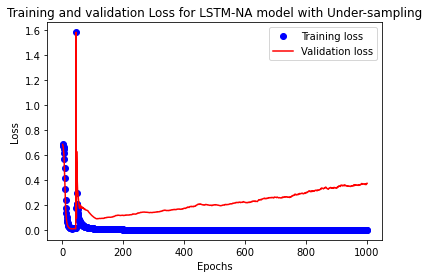

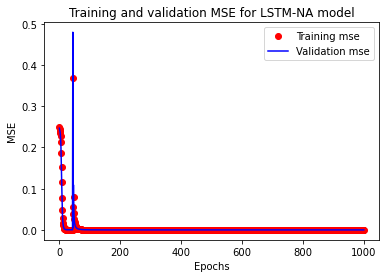

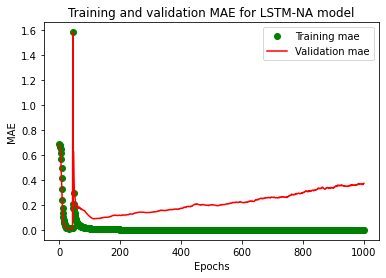

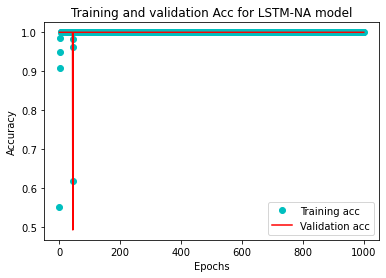

In [25]:
import matplotlib.pyplot as plt
loss = history_lstm.history['loss']
val_loss = history_lstm.history['val_loss']
mse = history_lstm.history['mse']
val_mse = history_lstm.history['val_mse']
mae = history_lstm.history['mae']
val_mae = history_lstm.history['val_mae']
acc = history_lstm.history['acc']
val_acc = history_lstm.history['val_acc']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation Loss for LSTM-NA model with Under-sampling')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, mse, 'ro', label='Training mse')
plt.plot(epochs, val_mse, 'b', label='Validation mse')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Training and validation MSE for LSTM-NA model')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, loss, 'go', label='Training mae')
plt.plot(epochs, val_loss, 'r', label='Validation mae')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('Training and validation MAE for LSTM-NA model')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, acc, 'co', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and validation Acc for LSTM-NA model')
plt.legend()
plt.show()


In [26]:
# save model
import h5py
model_lstm.save('large dataset/deep_model_resample_6features_undersampling-lstm_ec-sc.h5')
model_lstm.save_weights('large dataset/deep_model_resample_6features_undersampling-lstm_weights_ec-sc.h5')

## test tune model for real data

In [27]:
from keras.models import load_model
#del model_onelstm
model_onelstm = load_model('large dataset/deep_model_resample_6features_undersampling-lstm_ec-sc.h5')
model_onelstm.load_weights('large dataset/deep_model_resample_6features_undersampling-lstm_weights_ec-sc.h5', by_name=True)

In [32]:
# without resample
result_tr = model_onelstm.evaluate(X_train, y_train)
result_tr

8209/8209 [==============================] - 1s 73us/step


[0.0040236424058194735, 1.0, 0.00401556771248579, 1.612554660823662e-05]

In [33]:
%%time
out_tr=model_onelstm.predict(X_train)
out_tr

Wall time: 328 ms


array([[0.00398797, 0.9960121 ],
       [0.00398797, 0.9960121 ],
       [0.99595684, 0.00404311],
       ...,
       [0.00398797, 0.9960121 ],
       [0.00398797, 0.9960121 ],
       [0.00398797, 0.9960121 ]], dtype=float32)

In [34]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_train.argmax(axis=1), out_tr.argmax(axis=1)))

[[4109    0]
 [   0 4100]]


In [35]:
from sklearn.metrics import f1_score, precision_score, recall_score
print(precision_score(y_train.argmax(axis=1), out_tr.argmax(axis=1) , average="macro"))
print(recall_score(y_train.argmax(axis=1), out_tr.argmax(axis=1) , average="macro"))
print(f1_score(y_train.argmax(axis=1), out_tr.argmax(axis=1) , average="macro"))

1.0
1.0
1.0


In [28]:
# without resample
result_te = model_onelstm.evaluate(X_test, y_test)
result_te

913/913 [==============================] - 0s 144us/step


[0.004023338725682254, 1.0, 0.004015264101326466, 1.6123109162435867e-05]

In [29]:
%%time
out_te=model_onelstm.predict(X_test)
out_te

Wall time: 140 ms


array([[0.99595684, 0.00404311],
       [0.00398797, 0.9960121 ],
       [0.99595684, 0.00404311],
       ...,
       [0.00398797, 0.9960121 ],
       [0.00398797, 0.9960121 ],
       [0.99595684, 0.00404311]], dtype=float32)

In [30]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test.argmax(axis=1), out_te.argmax(axis=1)))

[[452   0]
 [  0 461]]


In [31]:
from sklearn.metrics import f1_score, precision_score, recall_score
print(precision_score(y_test.argmax(axis=1), out_te.argmax(axis=1) , average="macro"))
print(recall_score(y_test.argmax(axis=1), out_te.argmax(axis=1) , average="macro"))
print(f1_score(y_test.argmax(axis=1), out_te.argmax(axis=1) , average="macro"))

1.0
1.0
1.0


# test real data with undersampling model

In [39]:
# without resample
result_te = model_onelstm.evaluate(X_test, y_test)
result_te

28204445/28204445 [==============================] - 1971s 70us/step


[0.00405132665513873, 1.0, 0.0040810974314808846, 1.626261291676201e-05]

In [40]:
%%time
out_te=model_onelstm.predict(X_test)
out_te

Wall time: 19min 23s


array([[0.00398797, 0.9960121 ],
       [0.00398797, 0.9960121 ],
       [0.00398797, 0.9960121 ],
       ...,
       [0.99595684, 0.00404311],
       [0.99595684, 0.00404311],
       [0.99595684, 0.00404311]], dtype=float32)

In [41]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test.argmax(axis=1), out_te.argmax(axis=1)))

[[28199884        0]
 [       0     4561]]


In [42]:
from sklearn.metrics import f1_score, precision_score, recall_score
print(precision_score(y_test.argmax(axis=1), out_te.argmax(axis=1) , average="macro"))
print(recall_score(y_test.argmax(axis=1), out_te.argmax(axis=1) , average="macro"))
print(f1_score(y_test.argmax(axis=1), out_te.argmax(axis=1) , average="macro"))

1.0
1.0
1.0


# Train LSTM model for real data (without resample)

In [33]:
from keras import Sequential
from keras.layers import Dense,LSTM,Embedding
from keras import layers
import keras
callbacks_list = [keras.callbacks.EarlyStopping(monitor='acc',patience=1,),
keras.callbacks.ModelCheckpoint(filepath='my_model.h5',monitor='val_loss',save_best_only=True,)]

model_lstm = Sequential()

model_lstm.add(layers.Embedding(6, 8))
model_lstm.add(layers.LSTM(4))
model_lstm.add(Dense(2, activation='softmax'))
model_lstm.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['acc','mae','mse'])
model_lstm.summary()
history_lstm = model_lstm.fit(X_train, y_train,epochs=2,validation_split=0.2, callbacks=callbacks_list)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 8)           48        
_________________________________________________________________
lstm_2 (LSTM)                (None, 4)                 208       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 10        
Total params: 266
Trainable params: 266
Non-trainable params: 0
_________________________________________________________________
Train on 20307200 samples, validate on 5076800 samples
Epoch 1/2
20307200/20307200 [==============================] - 3979s 196us/step - loss: 0.0016 - acc: 0.9999 - mae: 5.7148e-04 - mse: 1.8825e-04 - val_loss: 0.0011 - val_acc: 0.9998 - val_mae: 3.0702e-04 - val_mse: 1.5160e-04
Epoch 2/2
20307200/20307200 [==============================] - 3954s 195us/step - loss: 0.0016 - acc: 0.9

In [34]:
# save model
import h5py
model_lstm.save('large dataset/deep_model_before_resample_6features_lstm_ec-sc.h5')
model_lstm.save_weights('large dataset/deep_model_before_resample_6features_lstm_weights_ec-sc.h5')

## Test Tune model for real data (without resample)

In [26]:
from keras.models import load_model
#del model
model_lstm = load_model('large dataset/deep_model_before_resample_6features_lstm_ec-sc.h5')
model_lstm.load_weights('large dataset/deep_model_before_resample_6features_lstm_weights_ec-sc.h5', by_name=True)

In [36]:
# without resample
result_tr = model_lstm.evaluate(X_train, y_train)
result_tr

25384000/25384000 [==============================] - 2011s 79us/step


[0.0017920834103681668,
 0.99989253282547,
 0.0007473152363672853,
 0.00016190006863325834]

In [37]:
%%time
out_tr=model_lstm.predict(X_train)
out_tr

Wall time: 21min 11s


array([[9.994142e-01, 5.858662e-04],
       [9.994142e-01, 5.858662e-04],
       [9.994142e-01, 5.858662e-04],
       ...,
       [9.994142e-01, 5.858662e-04],
       [9.994142e-01, 5.858662e-04],
       [9.994142e-01, 5.858662e-04]], dtype=float32)

In [38]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_train.argmax(axis=1), out_tr.argmax(axis=1)))

[[25379886        0]
 [    4114        0]]


In [39]:
from sklearn.metrics import f1_score, precision_score, recall_score
print(precision_score(y_train.argmax(axis=1), out_tr.argmax(axis=1) , average="macro"))
print(recall_score(y_train.argmax(axis=1), out_tr.argmax(axis=1) , average="macro"))
print(f1_score(y_train.argmax(axis=1), out_tr.argmax(axis=1) , average="macro"))

C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.4999189647021746
0.5
0.49995947906746147


In [40]:
# without resample
result_te = model_lstm.evaluate(X_test, y_test)
result_te

2820445/2820445 [==============================] - 214s 76us/step


[0.001765404671098096,
 0.9998415112495422,
 0.0007448680698871613,
 0.000158529554028064]

In [41]:
%%time
out_te=model_lstm.predict(X_test)
out_te

Wall time: 2min 22s


array([[9.994142e-01, 5.858662e-04],
       [9.994142e-01, 5.858662e-04],
       [9.994142e-01, 5.858662e-04],
       ...,
       [9.994142e-01, 5.858662e-04],
       [9.994142e-01, 5.858662e-04],
       [9.994142e-01, 5.858660e-04]], dtype=float32)

In [42]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test.argmax(axis=1), out_te.argmax(axis=1)))

[[2819998       0]
 [    447       0]]


In [43]:
from sklearn.metrics import f1_score, precision_score, recall_score
print(precision_score(y_test.argmax(axis=1), out_te.argmax(axis=1) , average="macro"))
print(recall_score(y_test.argmax(axis=1), out_te.argmax(axis=1) , average="macro"))
print(f1_score(y_test.argmax(axis=1), out_te.argmax(axis=1) , average="macro"))

0.49992075718547957
0.5
0.49996037545277916


# test other classifier without resample

In [78]:
x_tra,y_tra,x_tes,y_tes=X_train,y_train,X_test,y_test

In [79]:
X_train,y_train,X_test,y_test=x_tr,y_tr,x_te,y_te

In [89]:
%%time
# Linear Discriminant Analysis

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
print('Accuracy of LDA classifier on training set: {:.2f}'
     .format(lda.score(X_train, y_train)))
print('Accuracy of LDA classifier on test set: {:.2f}'
     .format(lda.score(X_test, y_test)))

Accuracy of LDA classifier on training set: 1.00
Accuracy of LDA classifier on test set: 1.00
Wall time: 2min 22s


In [90]:
%%time
from sklearn.metrics import f1_score, precision_score, recall_score,confusion_matrix
# Make predictions
preds_tr = lda.predict(X_train)
print(preds_tr)

# Evaluate accuracy
print(accuracy_score(y_train, preds_tr))

print(confusion_matrix(y_train, preds_tr))
print(precision_score(y_train, preds_tr , average="macro"))
print(recall_score(y_train, preds_tr , average="macro"))
print(f1_score(y_train, preds_tr , average="macro"))

['No' 'No' 'No' ... 'No' 'No' 'No']
0.9999761660888749
[[25379886        0]
 [     605     3509]]
0.9999880813968492
0.9264705882352942
0.9603115009448575
Wall time: 3min 56s


In [91]:
%%time
from sklearn.metrics import f1_score, precision_score, recall_score,confusion_matrix
# Make predictions
preds = lda.predict(X_test)
print(preds)

# Evaluate accuracy
print(accuracy_score(y_test, preds))

print(confusion_matrix(y_test, preds))
print(precision_score(y_test, preds , average="macro"))
print(recall_score(y_test, preds , average="macro"))
print(f1_score(y_test, preds , average="macro"))

['No' 'No' 'No' ... 'No' 'No' 'No']
0.9999726993435433
[[2819998       0]
 [     77     370]]
0.9999863478808187
0.9138702460850112
0.952869550836202
Wall time: 25.4 s


In [ ]:
%%time
# KNN
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
# time: one hour

In [5]:
%%time
from sklearn.metrics import f1_score, precision_score, recall_score,confusion_matrix
# Make predictions
preds_tr = knn.predict(X_train)
print(preds_tr)

# Evaluate accuracy
print(accuracy_score(y_train, preds_tr))

print(confusion_matrix(y_train, preds_tr))
print(precision_score(y_train, preds_tr , average="macro"))
print(recall_score(y_train, preds_tr , average="macro"))
print(f1_score(y_train, preds_tr , average="macro"))

['No' 'No' 'No' ... 'No' 'No' 'No']
0.9999808934762054
[[25379886        0]
 [     485     3629]]
0.9999904453721342
0.9410549343704424
0.9686766122826788
Wall time: 20min 4s


In [6]:
%%time
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix,accuracy_score
# Make predictions
preds =  knn.predict(X_test)
print(preds)

# Evaluate accuracy
print(accuracy_score(y_test, preds))

print(confusion_matrix(y_test, preds))
print(precision_score(y_test, preds , average="macro"))
print(recall_score(y_test, preds , average="macro"))
print(f1_score(y_test, preds , average="macro"))

['No' 'No' 'No' ... 'No' 'No' 'No']
0.9999709265736435
[[2819998       0]
 [     82     365]]
0.9999854614053503
0.9082774049217002
0.9495001197595498
Wall time: 2min 19s


In [7]:
%%time
# SVM
from sklearn.svm import SVC
svm = SVC()
svm.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svm.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svm.score(X_test, y_test)))

Accuracy of SVM classifier on training set: 1.00
Accuracy of SVM classifier on test set: 1.00
Wall time: 3h 29min 4s


In [8]:
%%time
from sklearn.metrics import f1_score, precision_score, recall_score,confusion_matrix,accuracy_score
# Make predictions
preds_tr = svm.predict(X_train)
print(preds_tr)

# Evaluate accuracy
print(accuracy_score(y_train, preds_tr))

print(confusion_matrix(y_train, preds_tr))
print(precision_score(y_train, preds_tr , average="macro"))
print(recall_score(y_train, preds_tr , average="macro"))
print(f1_score(y_train, preds_tr , average="macro"))

['No' 'No' 'No' ... 'No' 'No' 'No']
0.99998262685156
[[25379886        0]
 [     441     3673]]
0.999991312168673
0.9464025279533301
0.9716792312360152
Wall time: 42min 41s


In [9]:
%%time
from sklearn.metrics import f1_score, precision_score, recall_score,confusion_matrix,accuracy_score
# Make predictions
preds = svm.predict(X_test)
print(preds)

# Evaluate accuracy
print(accuracy_score(y_test, preds))

print(confusion_matrix(y_test, preds))
print(precision_score(y_test, preds , average="macro"))
print(recall_score(y_test, preds , average="macro"))
print(f1_score(y_test, preds , average="macro"))

['No' 'No' 'No' ... 'No' 'No' 'No']
0.9999840450709019
[[2819998       0]
 [     45     402]]
0.9999920213982553
0.9496644295302014
0.973494243882846
Wall time: 4min 42s
Parser   : 1.64 s
